In [185]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import pandas as pd

In [186]:
dataPath="Data/istanbul_deaths_2008_2020.csv"

# read the data to pandas data frame

In [3]:
rawdata = pd.read_csv(dataPath)

#  Convert the date column to date dtype #


In [4]:
rawdata["Date"]=pd.to_datetime(rawdata['Date'].astype(str), format='%d/%m/%Y')

 # Convert indexes to date index #

In [5]:
rawdata = rawdata.set_index('Date',drop="False")



# Plot the data #

Beware of the linear trend in data

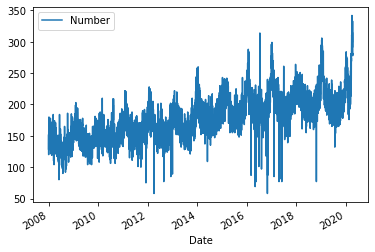

In [6]:
rawdata.plot()


# Calculate daily Crude death rate #

defined as 
 
 $$ \frac{number of deaths}{population} \times 100000 $$


first we need to insert population values. Since we dont have daily population we will approximate the population by yearly population.


### Insert population data

In [7]:
choices=[12697164,#8
12915158,#9
13255685,#10
13624240,#11
13854740,#12
14160467,#13
14377018,#14
14657434,#15
14804116,#16
15029231,#17
15067724,#18
15519267,#19
15713258#20         

]
conditions  = [rawdata.index.year == 2008,
               rawdata.index.year == 2009,
               rawdata.index.year == 2010,
               rawdata.index.year == 2011,
               rawdata.index.year == 2012,
               rawdata.index.year == 2013,
               rawdata.index.year == 2014,
               rawdata.index.year == 2015,
               rawdata.index.year == 2016,
               rawdata.index.year == 2017,
               rawdata.index.year == 2018,
               rawdata.index.year == 2019,
               rawdata.index.year == 2020]
       




In [8]:
rawdata["population"] = np.select(conditions, choices, default=np.nan)

In [9]:
rawdata["crudedaily"]=(rawdata["Number"]/rawdata["population"])*1E5

In [181]:
rawdata.head()

,Number,population,crudedaily
Date,,,
2008-01-01,129,12697164.0,1.015975
2008-01-02,152,12697164.0,1.197118
2008-01-03,120,12697164.0,0.945093
2008-01-04,157,12697164.0,1.236497
2008-01-05,128,12697164.0,1.008099


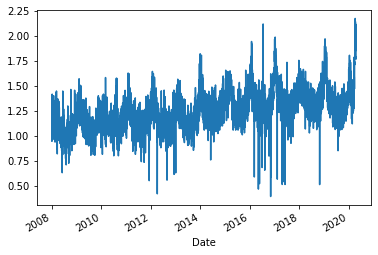

In [10]:
rawdata["crudedaily"].plot()

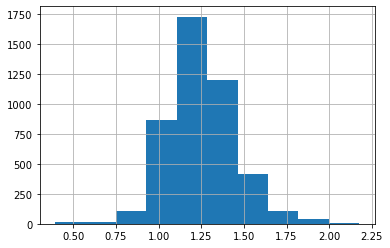

In [11]:
rawdata["crudedaily"].hist()

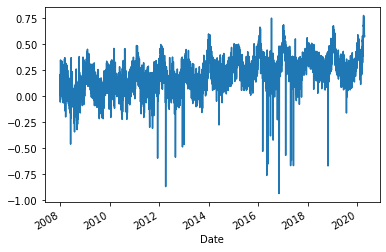

In [144]:
out=np.log(rawdata["crudedaily"])
out.plot()

## Resample  the data 
#  take seven daily average

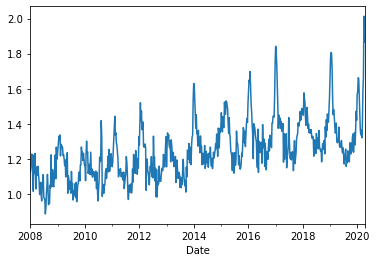

In [156]:
df7dayAve=rawdata.resample('7d').mean()
df7dayAve["crudedaily"].plot()


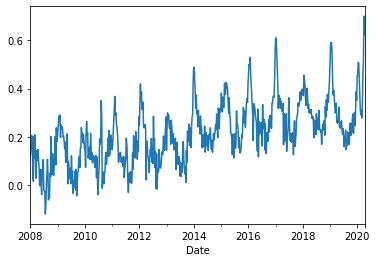

In [157]:
out7=np.log(df7dayAve["crudedaily"])
out7.plot( )
plt.plot(out7)

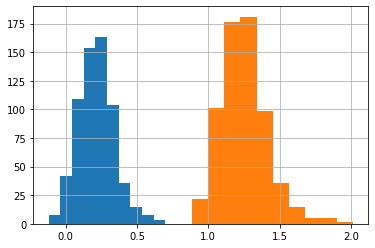

In [177]:

out7.hist()
df7dayAve["crudedaily"].hist()


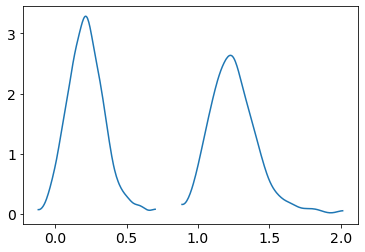

In [178]:
az.plot_kde(out7)
az.plot_kde(df7dayAve["crudedaily"])

# resample the data  take monthly average

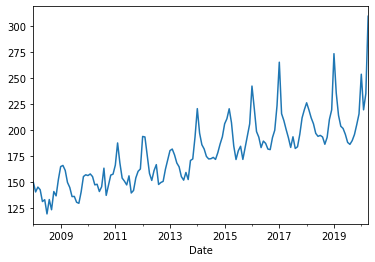

In [77]:
dfmothlyaverage=rawdata.resample('M').mean()
dfmothlyaverage["Number"].plot()

# resample the data take yearly average

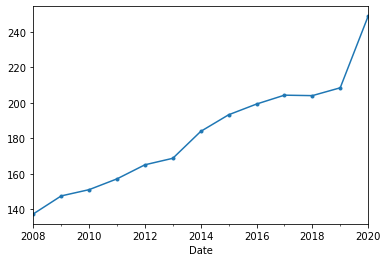

In [179]:
dfyearlyaverage=rawdata.resample('Y').mean()
dfyearlyaverage["Number"].plot(style='.-')

# Plot for crude death rate sampled 7days  

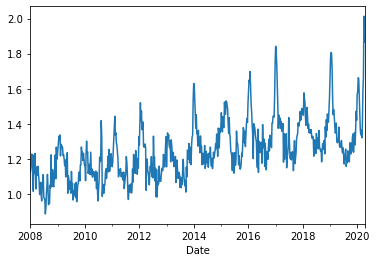

In [83]:
df7dayAve["crudedaily"].plot()

# Plot for crude death rate sampled Monthly 

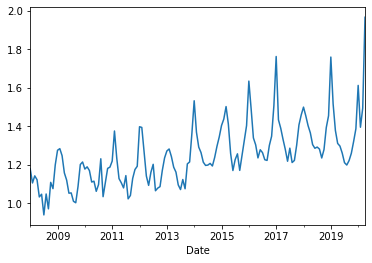

In [84]:
dfmothlyaverage["crudedaily"].plot()

# Plot for crude death rate sampled yearly


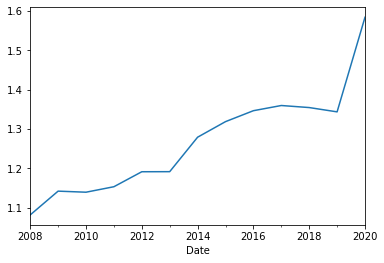

In [86]:
dfyearlyaverage["crudedaily"].plot()

# Check for seasonility for  year 2008#
i.e check for switch point in year 2008:

We will for now only concantrate on Numbers. Which are count data hence  using Poisson distribution
will be justified.

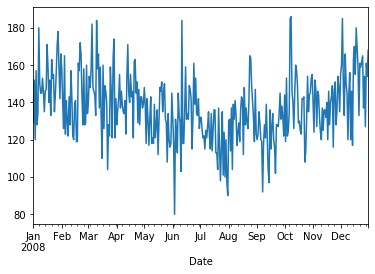

In [13]:
rawdata[rawdata.index.year==2008]["Number"].plot()


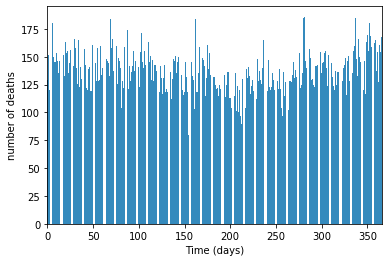

In [14]:

observeddata=rawdata[rawdata.index.year==2008]["Number"]
n_count_data = len(observeddata)
plt.bar(np.arange(n_count_data), observeddata, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("number of deaths")

plt.xlim(0, n_count_data);

## For 2008: Assume number of deaths are poisson ( which is defined by a lamda value). Do we have one lambda or more ( a change in distribution)?

$ C_i \sim \text{Poisson}(\lambda) $

$ \lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}$

$\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}$

$\begin{align}
& \tau \sim \text{DiscreteUniform(1,365) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{365}
\end{align}$
### What is alpha


 A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data


If, in reality, no sudden change occurred and indeed λ1=λ2, then the λs posterior distributions should look about equal.

# The model in pymc #

In [46]:
observeddata=rawdata[rawdata.index.year==2008]["Number"]
n_count_data = len(observeddata)
with pm.Model() as seasonal2008:
    alpha = 1.0/observeddata.mean()                                     
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    observation = pm.Poisson("observation", lambda_, observed=observeddata)
    
    

### Prior check

In [47]:
with seasonal2008:
     prior = pm.sample_prior_predictive(5000)

In [48]:
prior

{'lambda_2_log__': array([5.95006795, 0.64878389, 3.68792653, ..., 3.69955132, 4.3860474 ,
        4.42080385]),
 'lambda_1': array([503.71754759,   5.38296465, 103.30126321, ...,  57.79354396,
         67.95962202,  62.47251106]),
 'lambda_1_log__': array([6.22201569, 1.68323927, 4.6376496 , ..., 4.05687707, 4.21891374,
        4.13472664]),
 'observation': array([[516, 520, 496, ..., 365, 345, 354],
        [  2,   6,  11, ...,   2,   0,   4],
        [102, 104, 111, ...,  40,  50,  33],
        ...,
        [ 45,  61,  55, ...,  48,  48,  47],
        [ 71,  64,  81, ...,  64,  87,  89],
        [ 73,  49,  57, ...,  83,  81,  78]]),
 'tau': array([139,  76,  45, ..., 299, 104,  61]),
 'lambda_2': array([383.77941739,   1.91321274,  39.9619012 , ...,  40.42916041,
         80.32230838,  83.16310952])}

array([<matplotlib.axes._subplots.AxesSubplot object at 0x129958220>],
      dtype=object)

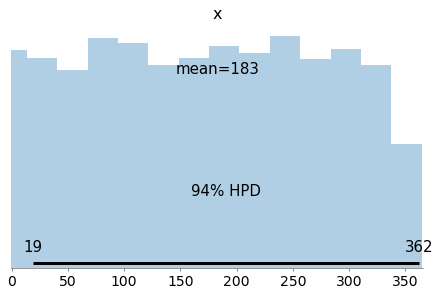

In [49]:
az.plot_posterior(prior["tau"])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1297b5460>],
      dtype=object)

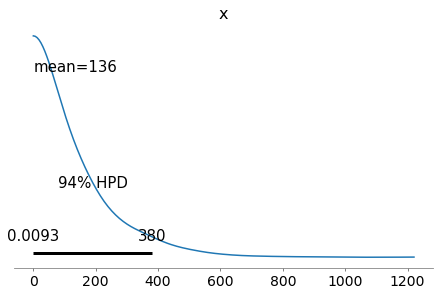

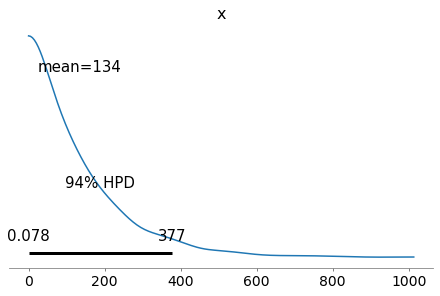

In [50]:
az.plot_posterior(prior["lambda_1"])
az.plot_posterior(prior["lambda_2"])

# Calculate the posterior distribution

In [51]:
with seasonal2008:#trace_4_3 = pm.sample(1000, tune=1000)#trace = pm.sample(10000, tune=5000,step=step)
     trace2008 = pm.sample(10000, tune=5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 41 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12ddfc280>,
      dtype=object)

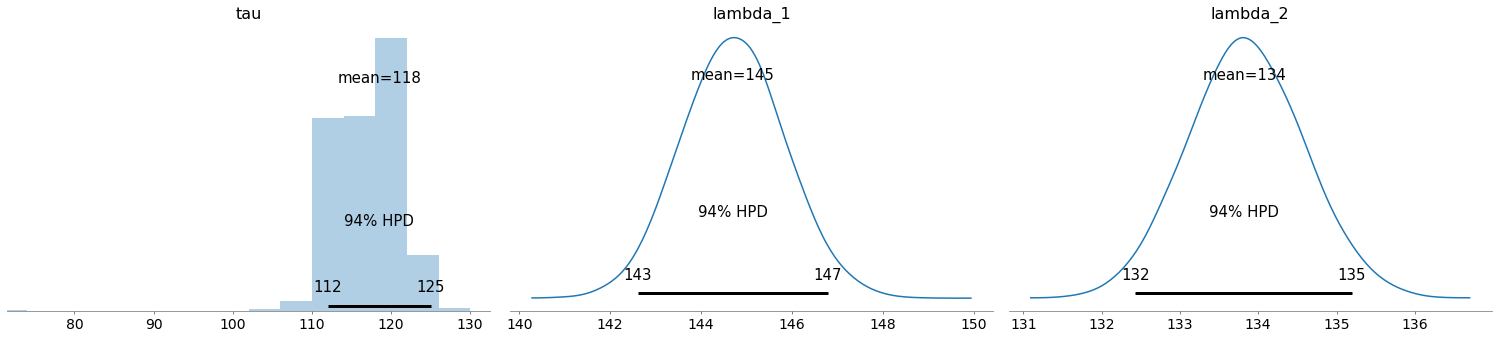

In [53]:
az.plot_posterior(trace2008)

## Question 0 )What are the plausible values for the parameters λ1 and λ2?
Are  λ valeus distinct (indicating that it is indeed likely that there was a change in the data)?
Which day is the most possible candidate for change (most possible Tau)?

In [54]:
ppc = pm.sample_posterior_predictive(trace2008, samples=1000, model=seasonal2008)

/Users/gokhansahin/opt/anaconda3/envs/stat-rethink2-pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1584: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


## Posterior  Predictive check


In [127]:
trace2008

<MultiTrace: 2 chains, 10000 iterations, 5 variables>

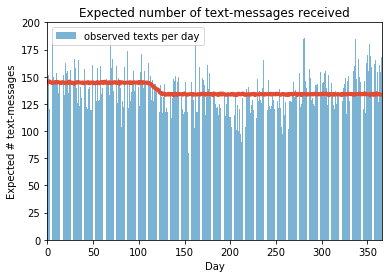

In [129]:
plt.plot( ppc["observation"].mean(0), lw=4, color="#E24A33")

plt.xlim(0, len(observeddata))

plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 200)
plt.bar(np.arange(len(observeddata)), observeddata, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");


### credible interval for the count data

/Users/gokhansahin/opt/anaconda3/envs/stat-rethink2-pymc3/lib/python3.8/site-packages/arviz/data/base.py:141: UserWarning: More chains (1000) than draws (366). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


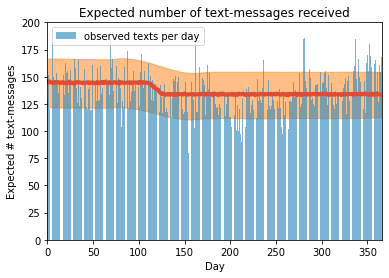

In [130]:
plt.plot( ppc["observation"].mean(0), lw=4, color="#E24A33")

plt.xlim(0, len(observeddata))
az.plot_hpd(np.arange(len(observeddata)), ppc["observation"])
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 200)
plt.bar(np.arange(len(observeddata)), observeddata, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");


# Question 1 Repeat the same procedure for the years
a)2009
b)2010
c)2011
d)2012
e)2018 <date<=2020 
(rawdata[(rawdata.index.year>2018) & (rawdata.index.year<2021)]["Number"])

Did all the models worked or did you get an error ( if you get an error probably it is your model)?
İf some of them work like 2008 data why (hint check yearly average)?



# Question 2  #

Below you are given the model for 3 switch points apply it to all the data.
Does it work? if not why?

## 3 switch point




In [ ]:
observeddata=?



with pm.Model() as model3switch:
    alpha = 1.0/observeddata.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)
    
    tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data)
    tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data)
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau_2 >= idx, pm.math.switch(tau_1 >= idx, lambda_1, lambda_2), lambda_3)
    observation3switch = pm.Poisson("observation3switch", lambda_, observed=observeddata2009)
    trace2009 = pm.sample(10000, tune=1000)


# Question 4)  Repeat the procedures above for 
  ## i) for  7 daily average
  ## ii) monthly average

# Question 5) do the above analysis   for crude death rate ("crudedaily ") column. (can you still use poisson distribution for the out come. Why or Why not?

(poisson distribution is usefull for count data)

# Question 6 #

Since there is apperent  trend in data  try to model it by  assuming crude daily=a+b*t+N(mu,sigma)
or in bayesien language do a linear regression specified by
crudedaily ~ N(mu,sigma)
mu=a+b*t
a=?
b=?
sigma=?

Is simulation better ?



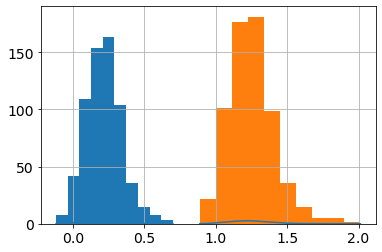

In [183]:
# Recall out7=np.log(df7dayAve["crudedaily"]), ie log of 7dayaverage of daily crude death rate
out7.hist()
df7dayAve["crudedaily"].hist()


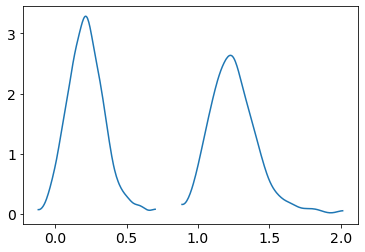

In [184]:
az.plot_kde(out7)
az.plot_kde(df7dayAve["crudedaily"])


# Question 7 do a poisson regression

Using the number columns do a poisson regression ie:
numbers ~ poisson(lambda)
lambda=a+b*t
a=?
b=?